# Bonus Assignment 1 - Obtain More Accurate Locations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import geopandas as gpd


In [2]:
# Import the cleaned roads dataset
roads = pd.read_csv('_roads3.csv')
display(roads.head())
gdf = gpd.GeoDataFrame(roads, geometry=gpd.points_from_xy(roads.lon, roads.lat))

,road,chainage,lrp,lat,lon,gap,type,name
0,N1,0.000,LRPS,23.706028,90.443333,NaN,Others,Start of Road after Jatrabari Flyover infront...
1,N1,0.814,LRPSa,23.702917,90.450417,NaN,Culvert,Box Culvert
2,N1,0.822,LRPSb,23.702778,90.450472,NaN,CrossRoad,Intersection with Z1101
3,N1,1.000,LRP001,23.702139,90.451972,NaN,KmPost,Km post missing
4,N1,2.000,LRP002,23.697889,90.460583,NaN,KmPost,Km post missing


In [3]:
# Plot function to plot the roads on a map
def plot_roads(gdf, label0, title, highlight=None, highlight_label=None, highlight2=None, highlight_label2=None):
    fig, ax = plt.subplots(figsize=(8,8))
    gdf.plot(ax=ax, color='blue', markersize=1, label=label0)
    
    if highlight is not None:
        highlight.plot(ax=ax, color='red', markersize=3, label=highlight_label)
    
    if highlight2 is not None:
        highlight2.plot(ax=ax, color='green', markersize=3, label=highlight_label2)

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_aspect('equal')
    fig.suptitle(title, fontsize=15)
    fig.tight_layout()
    plt.legend()
    plt.show()
    

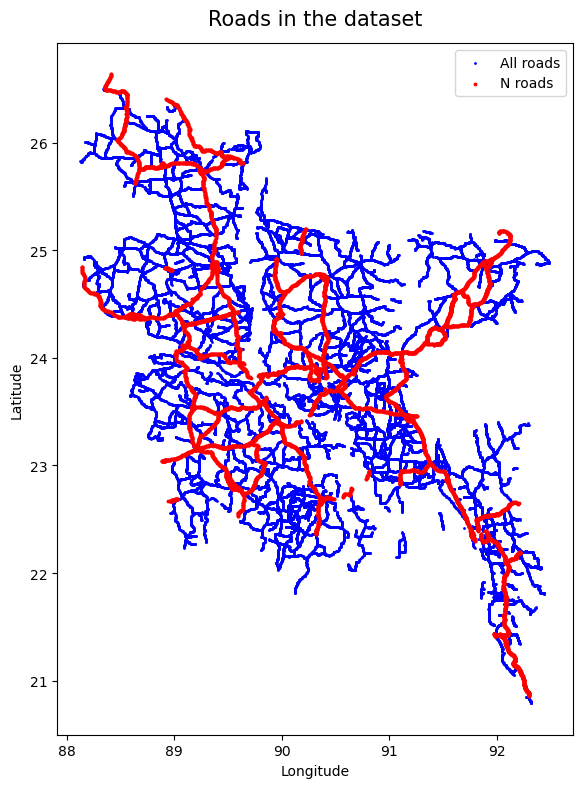

In [4]:
plot_roads(gdf, 'All roads', 'Roads in the dataset', highlight=gdf[gdf['road'].str.contains('N')], highlight_label='N roads')

### Identification of the N roads with intersections to the N1 and N2

In [5]:
n_roads = gdf[gdf['road'].str.contains('N')]
n1 = n_roads[n_roads['road'] == 'N1']
n2 = n_roads[n_roads['road'] == 'N2']

C:\Users\groen\AppData\Local\Temp\ipykernel_24360\241126478.py:5: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buffer_union = n_main['buffer_geom'].unary_union


Roads intersecting the N1 or N2 and longer than 25 km: ['N1' 'N102' 'N104' 'N105' 'N2' 'N204' 'N207' 'N208']


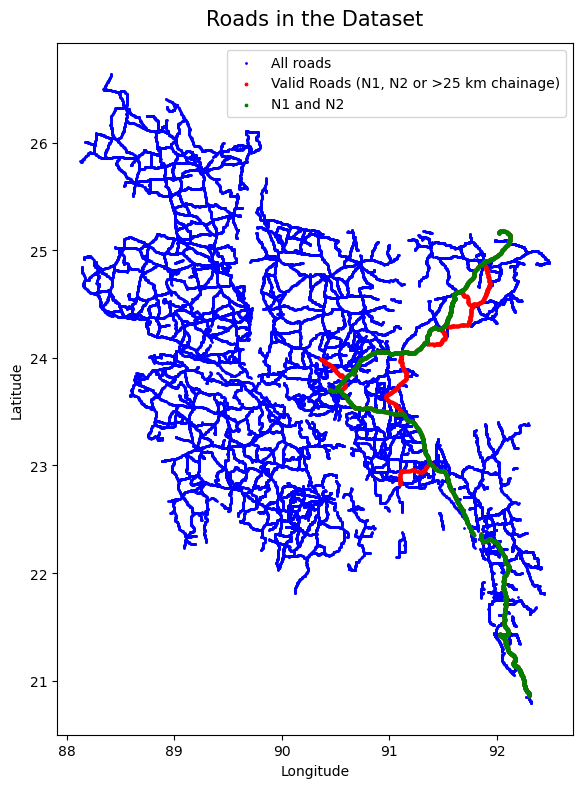

In [6]:
n_main = gpd.GeoDataFrame(pd.concat([n1, n2], ignore_index=True), crs=n1.crs)
n_main['buffer_geom'] = n_main.geometry.buffer(0.18)

# Combine all buffer geometries into a single geometry using unary_union
buffer_union = n_main['buffer_geom'].unary_union
roads_within = n_roads[n_roads.geometry.intersects(buffer_union)]

max_chainage = roads_within.groupby('road')['chainage'].max().reset_index()

# Filter: always include N1 and N2; for side roads, only include if max chainage > 25 km
valid_roads = max_chainage[
    (max_chainage['road'].isin(['N1', 'N2'])) |
    (max_chainage['chainage'] > 25)
]

# Filter the original roads based on the valid roads list
valid_roads = gdf[gdf['road'].isin(valid_roads['road'])]
print(f'Roads intersecting the N1 or N2 and longer than 25 km: {valid_roads.road.unique()}')

# Plot the final roads
plot_roads(
    gdf, 
    label0='All roads', 
    title='Roads in the Dataset', 
    highlight=valid_roads, 
    highlight_label='Valid Roads (N1, N2 or >25 km chainage)', 
    highlight2=n_main, 
    highlight_label2='N1 and N2'
)

### Identify the intersection locations of the roads

,road,chainage,lrp,lat,lon,gap,type,name,geometry
0,N1,0.822,LRPSb,23.702778,90.450472,NaN,CrossRoad,Intersection with Z1101,POINT (90.45047 23.70278)
1,N1,7.181,LRP007a,23.697916,90.509278,NaN,CrossRoad,"R110,Left to Demra, Right to Narayanganj",POINT (90.50928 23.69792)
2,N1,85.897,LRP088a,23.459000,91.142333,NaN,CrossRoad,Cross road Z1029,POINT (91.14233 23.459)
3,N1,87.366,LRP089c,23.446944,91.148139,NaN,CrossRoad,Cross Road with Z1052,POINT (91.14814 23.44694)
4,N1,91.583,LRP094a,23.419138,91.172194,NaN,CrossRoad,Left to Comilla Right to Noakhali,POINT (91.17219 23.41914)
5,N1,140.251,LRP143a,23.047944,91.365139,NaN,CrossRoad,Z1031,POINT (91.36514 23.04794)
6,N1,145.409,LRP148a,23.009556,91.381360,NaN,CrossRoad / KmPost,Intersection with N104 / Km post missing,POINT (91.38136 23.00956)
7,N1,255.726,LRP259b,22.309694,91.915750,NaN,CrossRoad,Road to Kaliganj (Z1070),POINT (91.91575 22.30969)
8,N1,330.874,LRP335c,21.773722,92.084055,NaN,CrossRoad,Intersection with Z1126,POINT (92.08406 21.77372)
9,N1,0.000,LRPS,23.706028,90.443333,NaN,Others,Start of Road after Jatrabari Flyover infront...,POINT (90.44333 23.70603)


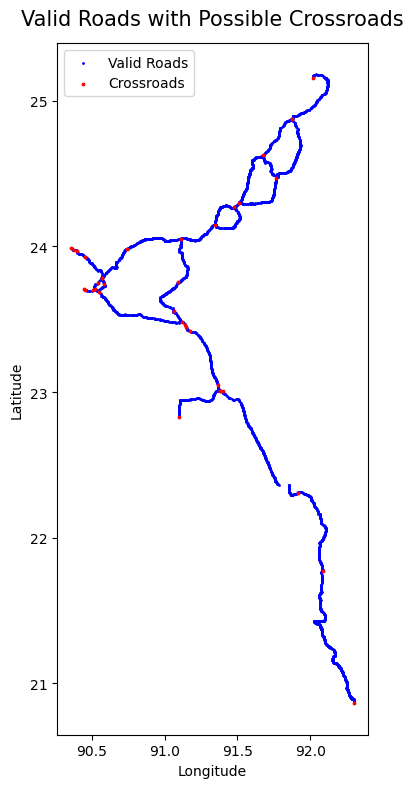

In [7]:
# Loop through each road in valid roads, and display the crossroads
crossroads_list = []
for road in valid_roads['road'].unique():
    road_data = valid_roads[valid_roads['road'] == road]
    crossroads = road_data[road_data['type'].str.contains('CrossRoad')]

    # Add the beginning and end points of the road to the crossroads
    crossroads = pd.concat([crossroads, road_data.iloc[[0, -1]]])
    crossroads_list.append(crossroads)

possible_crossroads = pd.concat(crossroads_list, ignore_index=True)
display(possible_crossroads)

plot_roads(valid_roads, 'Valid Roads', 'Valid Roads with Possible Crossroads', highlight=possible_crossroads, highlight_label='Crossroads')


,road,chainage,lrp,lat,lon,gap,type,name,geometry
6,N1,145.409,LRP148a,23.009556,91.381360,NaN,CrossRoad / KmPost,Intersection with N104 / Km post missing,POINT (91.38136 23.00956)
13,N102,0.000,LRPS,23.478972,91.118194,NaN,Others,Start of road from N1 Mainamati,POINT (91.11819 23.47897)
14,N102,82.682,LRPE,24.050611,91.114667,NaN,Others,Meet with N 2 at Sanail,POINT (91.11467 24.05061)
15,N104,1.878,LRP001a,23.009528,91.381444,NaN,CrossRoad,Right to Comilla Left to Chittagong,POINT (91.38144 23.00953)
19,N105,12.803,LRP012a,23.785194,90.568805,NaN,CrossRoad,N2 Dhaka-Sylhet -Jaflong Road,POINT (90.5688 23.78519)
23,N105,0.000,LRPS,23.690416,90.546611,NaN,Others,"Starts of road from N1,Dhaka teknaf road at Ma...",POINT (90.54661 23.69042)
26,N2,11.464,LRP012a,23.785333,90.568555,NaN,CrossRoad,Intersection with N105,POINT (90.56855 23.78533)
28,N2,0.000,LRPS,23.705917,90.521444,NaN,Others,Road Start from N1 at Katchpur,POINT (90.52144 23.70592)
30,N204,0.000,LRPS,24.147916,91.346611,NaN,Others,Road start from N2 at Jagannathganj.,POINT (91.34661 24.14792)
31,N204,34.421,LRPE,24.267388,91.477138,NaN,Others,Road End intersecting N2 at Shaistagonj Round ...,POINT (91.47714 24.26739)


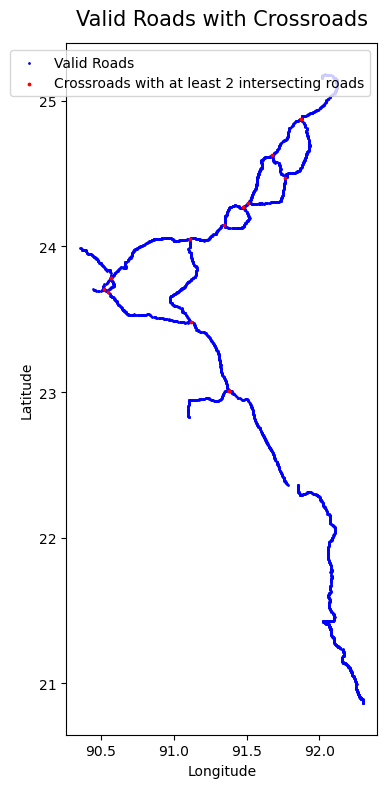

In [8]:
# check if these possible crossroads intersect with at least 2 roads
crossroad_intersections = []

def check_crossroad_intersections(possible_crossroads, valid_roads):
    # Create a small buffer around each possible crossroad
    possible_crossroads['buffer_geom'] = possible_crossroads.geometry.buffer(0.005)

    for idx, crossroad in possible_crossroads.iterrows():
        # Check how many roads intersect with the buffer
        roads_intersecting = valid_roads[valid_roads.geometry.intersects(crossroad['buffer_geom'])]
        if roads_intersecting['road'].nunique() >= 2:
            crossroad_intersections.append(crossroad)

    return

check_crossroad_intersections(possible_crossroads, valid_roads)
crossroad_intersections = pd.DataFrame(crossroad_intersections).drop(columns='buffer_geom')
crossroad_intersections = gpd.GeoDataFrame(crossroad_intersections, geometry='geometry')
display(crossroad_intersections)

plot_roads(valid_roads, 'Valid Roads', 'Valid Roads with Crossroads', highlight=crossroad_intersections, highlight_label='Crossroads with at least 2 intersecting roads')

These are the correct crossroads, however there are a few duplicate locations, with almost the same latitude and longitude. These duplicates will first be identified.


In [14]:
# Identify the (almost) duplicate locations

# Create a small buffer around each crossroad
crossroad_intersections['buffer_geom'] = crossroad_intersections.geometry.buffer(0.001)

# Check for intersections between the buffers
crossroad_duplicates = []
for idx, crossroad in crossroad_intersections.iterrows():
    intersections = crossroad_intersections[crossroad_intersections.geometry.intersects(crossroad['buffer_geom'])]
    if len(intersections) > 1:
        crossroad_duplicates.append(intersections.index)

display(crossroad_duplicates)

[Index([6, 15], dtype='int64'),
 Index([6, 15], dtype='int64'),
 Index([19, 26], dtype='int64'),
 Index([19, 26], dtype='int64')]

So the duplicate crossroads are the one with index 6 & 15, and the one with index 19 & 26. In both cases we choose to keep the locations of the crossroad whcihc point originates from the N1 or N2 road data. The other ones are dropped in the code below.

In [21]:
# Remove the duplicates
try:
    crossroad_intersections = crossroad_intersections.drop(index=15)
    crossroad_intersections = crossroad_intersections.drop(index=19)
except KeyError:
    pass

# Remove the buffer geometry
try:
    crossroad_intersections = crossroad_intersections.drop(columns='buffer_geom')
except KeyError:
    pass

# display the final crossroads
display(crossroad_intersections)

,road,chainage,lrp,lat,lon,gap,type,name,geometry
6,N1,145.409,LRP148a,23.009556,91.381360,NaN,CrossRoad / KmPost,Intersection with N104 / Km post missing,POINT (91.38136 23.00956)
13,N102,0.000,LRPS,23.478972,91.118194,NaN,Others,Start of road from N1 Mainamati,POINT (91.11819 23.47897)
14,N102,82.682,LRPE,24.050611,91.114667,NaN,Others,Meet with N 2 at Sanail,POINT (91.11467 24.05061)
19,N105,12.803,LRP012a,23.785194,90.568805,NaN,CrossRoad,N2 Dhaka-Sylhet -Jaflong Road,POINT (90.5688 23.78519)
23,N105,0.000,LRPS,23.690416,90.546611,NaN,Others,"Starts of road from N1,Dhaka teknaf road at Ma...",POINT (90.54661 23.69042)
26,N2,11.464,LRP012a,23.785333,90.568555,NaN,CrossRoad,Intersection with N105,POINT (90.56855 23.78533)
28,N2,0.000,LRPS,23.705917,90.521444,NaN,Others,Road Start from N1 at Katchpur,POINT (90.52144 23.70592)
30,N204,0.000,LRPS,24.147916,91.346611,NaN,Others,Road start from N2 at Jagannathganj.,POINT (91.34661 24.14792)
31,N204,34.421,LRPE,24.267388,91.477138,NaN,Others,Road End intersecting N2 at Shaistagonj Round ...,POINT (91.47714 24.26739)
32,N207,0.000,LRPS,24.294861,91.510250,NaN,Others,Road start from N2 at Mirpur.,POINT (91.51025 24.29486)


# Bonus exercise 2 - Compare the new locations with the approximate locations used